In [33]:
import json
import itertools
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [49]:
# Load data
artists_dict = json.load(open("data/artists_100k.json", "r"))
related_dict = json.load(open("data/related_100k.json", "r"))

In [54]:
# Genre analysis using all 100,000 artists
genre_set = set()
champ = 0
champ_name = ""
for artist_info in artists_dict.values():
    genres = artist_info["genres"]
    if len(genres) > champ:
        champ = len(genres)
        champ_name = artist_info["name"]
    for genre in genres:
        genre_set.add(genre)
print("Total: ", len(genre_set))
print(champ_name, champ)

Total:  3847
Wire 29


In [35]:
# Build graph using 1,000 artists
G = nx.Graph()
for artist, related in related_dict.items():
    for next_artist in related:
        G.add_edge(artist, next_artist)

In [36]:
# Print basic graph properties
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())
connected = nx.is_connected(G)
print("Connectivity: ", connected)
print("Components:", len(list(nx.connected_components(G))))

Number of nodes:  1013
Number of edges:  3282
Connectivity:  False
Components: 3


In [37]:
# Partition graph
def partition(n, graph):
    comp = nx.community.girvan_newman(graph)
    limited = itertools.takewhile(lambda c: len(c) <= n, comp)
    return list(limited)[-1]

In [38]:
communities = partition(5, G)

In [48]:
# Get center of each partition
labels = {}
for community in communities:
    sub = G.subgraph(list(community))
    sub_close = nx.closeness_centrality(sub)
    center = max(sub_close, key=sub_close.get)
    labels[center] = artists_dict[center]["name"]
    print(artists_dict[center]["name"], artists_dict[center]["genres"])

Post Malone ['dfw rap', 'melodic rap', 'rap']
Camila Cabello ['dance pop', 'pop', 'post-teen pop']
Cardi B ['pop', 'pop rap', 'rap']
Luke Combs ['contemporary country']
Panic! At The Disco ['baroque pop', 'emo', 'modern rock']


In [40]:
# Generate colors and labels for graph
colors = []
for node in G.nodes():
    for i in range(len(communities)):
        if node in communities[i]:
            colors.append(i)

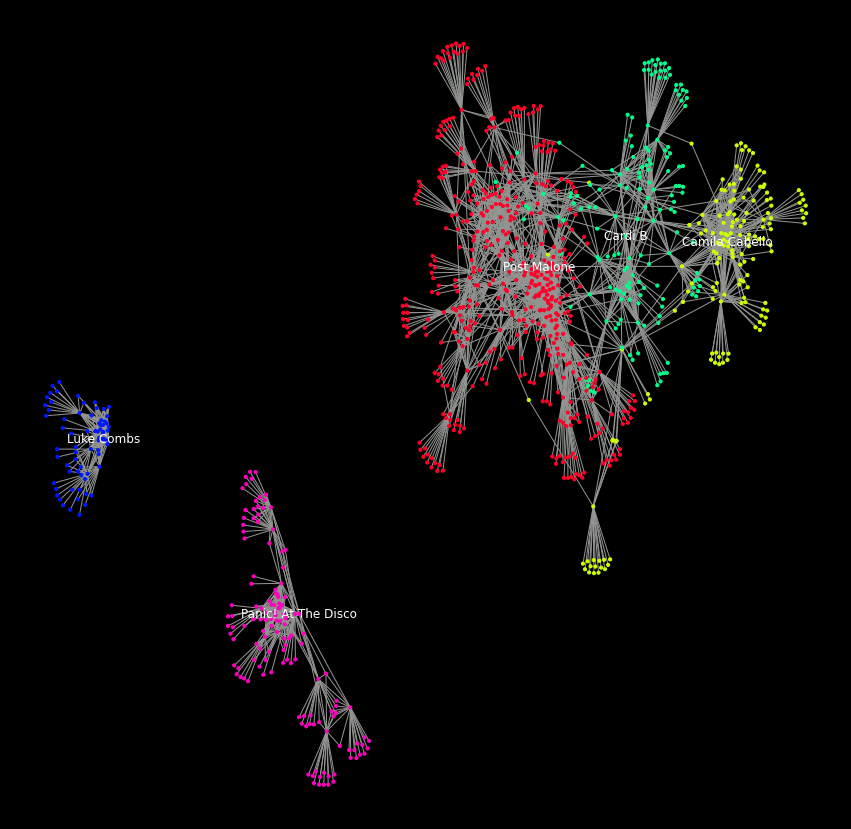

In [41]:
# Draw graph
fig, ax = plt.subplots(figsize=(15,15))
nx.draw_networkx(G, node_size=10, edge_color="#929591", cmap=plt.cm.gist_rainbow, node_color=colors, labels=labels, font_color="w")
ax.axis("off")
fig.set_facecolor('k')
plt.show()